In [25]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np

import os

In [26]:
in_submission = os.path.exists('/flags/isgrader.flag')
perform_computation = not in_submission 

if in_submission:
    assert os.path.exists('./cifar_net.pth'), 'The trained network for CIFAR was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'
    
    assert os.path.exists('./mnist_net.pth'), 'The trained network for MNIST was not stored properly. ' + \
                                              'Please read and follow the instructions/important notes.'

# *Assignment Summary

Go through the CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, and ensure you can run the code. Modify the architecture that is offered in the CIFAR-10 tutorial to get the best accuracy you can. Anything better than about 93.5% will be comparable with current research. 

Redo the same efforts for the MNIST digit data set.

**Procedural Instructions**:

This assignment is less guided than the previous assignments. You are supposed to train a deep convolutional classifier, and store it in a file. The autograder will load the trained model, and test its accuracy on a hidden test data set. Your classifier's test accuracy will determine your grade for each part according to the following model.

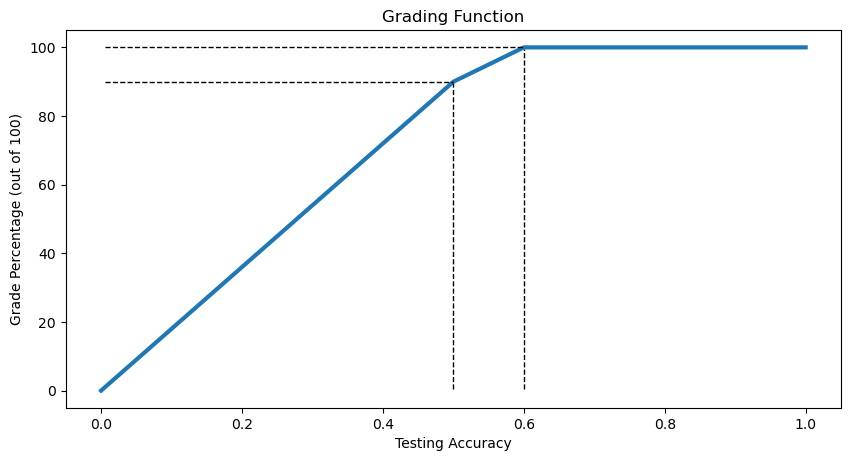

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ax.plot([0., 0.5, 0.6, 1.], [0., 90., 100., 100.], lw=3)
ax.axhline(y=90, xmin=0.05, xmax=.5, lw=1, ls='--', c='black')
ax.axvline(x=0.5, ymin=0.05, ymax=.86, lw=1, ls='--', c='black')
ax.axhline(y=100, xmin=0.05, xmax=.59, lw=1, ls='--', c='black')
ax.axvline(x=0.6, ymin=0.05, ymax=.95, lw=1, ls='--', c='black')
ax.set_xlabel('Testing Accuracy')
ax.set_ylabel('Grade Percentage (out of 100)')
ax.set_title('Grading Function')
None

# <span style="color:red">Important Notes</span>

You **should** read these notes before starting as these notes include crucial information about what is expected from you.

1. **Use Pytorch**: The autograder will only accept pytorch models.

  * Pytorch's CIFAR-10 tutorial at https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html is the best starting point for this assignment. However, we will not prohibit using or learning from any other tutorial you may find online.


2. **No Downloads**: The coursera machines are disconnected from the internet. We already have downloaded the pytorch data files, and uploaded them for you. You will need to disable downloading the files if you're using data collector APIs such as `torchvision.datasets`.
  * For the CIFAR data, you should provide the `root='/home/jovyan/work/release/CNN-lib/data_cifar', download=False` arguments to the `torchvision.datasets.CIFAR10` API.
  * For the MNIST data, you should provide the `root='/home/jovyan/work/release/CNN-lib/data_mnist', download=False` arguments to the `torchvision.datasets.MNIST` API.


3. **Store the Trained Model**: The autograder can not and will not retrain your model. You are supposed to train your model, and then store your best model with the following names:

  * The CIFAR classification model must be stored at `./cifar_net.pth`. 
  * The MNIST classification model must be stored at `./mnist_net.pth`.
  * Do not place these file under any newly created directory.
  * The trained model may **not exceed 1 MB** in size.


4. **Model Class Naming**: The neural models in the pytorch library are subclasses of the `torch.nn.Module` class. While you can define any architecture as you please, your `torch.nn.Module` must be named `Net` exactly. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```


5. **Grading Reference Pre-processing**: We will use a specific randomized transformation for grading that can be found in the `Autograding and Final Tests` section. Before training any model for long periods of time, you need to pay attention to the existence of such a testing pre-processing.

6. **Training Rules**: You are able to make the following decisions about your model:

  * You **can** choose and change your architecture as you please. 
      * You can have shallow networks, or deep ones.
      * You can customize the number of neural units in each layer and the depth of the network.
      * You are free to use convolutional, and non-convolutional layers.
      * You can employ batch normalization if you would like to.
      * You can use any type of non-linear layers as you please. `Tanh`, `Sigmoid`, and `ReLU` are some common activation functions.
      * You can use any kind of pooling layers you deem appropriate.
      * etc.
   * You **can** initialize your network using any of the methods described in `https://pytorch.org/docs/stable/nn.init.html`.
      * Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.
      * You may want to avoid initializing your network with all zeros (think about the symmetry of the neural units, and how identical initialization may be a bad idea considering what happens during training).
   * You **can** use and customize any kind of optimization methods you deem appropriate.
      * You can use any first order stochastic methods (i.e., Stochastic Gradient Descent variants) such as Vanilla SGD, Adam, RMSProp, Adagrad, etc.
      * You are also welcome to use second order optimization methods such as newton and quasi-newton methods. However, it may be expensive and difficult to make them work for this setting.
      * Zeroth order methods (i.e., Black Box methods) are also okay (although you may not find them very effective in this setting).
      * You can specify any learning rates first order stochastic methods. In fact, you can even customize your learning rate schedules.
      * You are free to use any mini-batch sizes for stochastic gradient computation.
      * etc.
   * You **can** use any kind of loss function you deem effective.
      * You can add any kind of regularization to your loss.
      * You can pick any kind of classification loss functions such as the cross-entropy and the mean squared loss. 
   * You **cannot** warm-start your network (i.e., you **cannot** use a pre-trained network).
   * You **may** use any kind of image pre-processing and transformations during training. However, for the same transformations to persist at grading time, you may need to apply such transformations within the neural network's `forward` function definition. 
      * In other words, we will drop any `DataLoader` or transformations that your network may rely on to have good performance, and we will only load and use your neural network for grading.

# 1. Object Classification Using the CIFAR Data

## 1.1 Loading the Data

You **may** use any kind of image pre-processing and transformations during training. However, for the same transformations to persist at grading time, you may need to apply such transformations within the neural network's `forward` function definition. 
      * In other words, we will drop any `DataLoader` or transformations that your network may rely on to have good performance, and we will only load and use your neural network for grading.

2. **No Downloads**: The coursera machines are disconnected from the internet. We already have downloaded the pytorch data files, and uploaded them for you. You will need to disable downloading the files if you're using data collector APIs such as `torchvision.datasets`.
  * For the CIFAR data, you should provide the `root='/home/jovyan/work/release/CNN-lib/data_cifar', download=False` arguments to the `torchvision.datasets.CIFAR10` API.
  * For the MNIST data, you should provide the `root='/home/jovyan/work/release/CNN-lib/data_mnist', download=False` arguments to the `torchvision.datasets.MNIST` API.
  
**IS THIS RELEVENT HERE TOO?**
Grading Reference Pre-processing: We will use a specific randomized transformation for grading that can be found in the Autograding and Final Tests section. Before training any model for long periods of time, you need to pay attention to the existence of such a testing pre-processing.

**WHAT ABOUT:**
   * You **may** use any kind of image pre-processing and transformations during training. However, for the same transformations to persist at grading time, you may need to apply such transformations within the neural network's `forward` function definition. 
      * In other words, we will drop any `DataLoader` or transformations that your network may rely on to have good performance, and we will only load and use your neural network for grading.

##### Notes:
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

In [4]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Beginning of Mo's code 

## TUTORIAL:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
    transforms.RandomAffine(degrees=30, translate=(0.01, 0.01), scale=(0.9, 1.1), shear=None, resample=0, fillcolor=0),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

# TUTORIAL:

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)

#AUTOGRADER:

trainset = torchvision.datasets.CIFAR10(root='/home/jovyan/work/release/CNN-lib/data_cifar', train=True,
                                        download=False, transform=transform)
 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#TUTORIAL
# testset = torchvision.datasets.CIFAR10(root='./data', train=False,
#                                        download=True, transform=transform)

#AUTOGRADER:
testset = torchvision.datasets.CIFAR10(root='/home/jovyan/work/release/CNN-lib/data_cifar', train=False,
                                       download=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
# End of Mo's code

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet above, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).


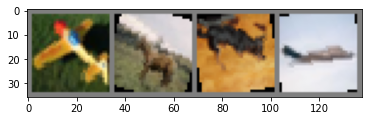

plane horse dog   plane


In [5]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)

# Beginning of Mo's code 

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# End of Mo's code

# 1.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```

##### Notes:
Recall from note 2 **training rules**
  * You **can** choose and change your **architecture** as you please. 
      * levels: You can have shallow or deep networks.
      * You can customize the number of neural **units in each layer** and the **depth** of the network.
      * You are free to use **convolutional, and non-convolutional** layers.
      * You can employ **batch normalization** if you would like to.
      * You can use any type of **non-linear layers** as you please. `Tanh`, `Sigmoid`, and `ReLU` are some common activation functions.
      * You can use any kind of **pooling layers** you deem appropriate.
      * etc.

2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined)

In [6]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)

# Beginning of Mo's code 

# You can define the neural architecture and instantiate it in this cell.
# You can choose and change your architecture as you please.
    # You can have shallow networks, or deep ones.
    # You can customize the number of neural units in each layer and the depth of the network.
    # You are free to use convolutional, and non-convolutional layers. (self.sonv1 & self.conv2?)
    # You can employ batch normalization if you would like to.
    # You can use any type of non-linear layers as you please. Tanh, Sigmoid, and ReLU are some common activation functions.
    # You can use any kind of pooling layers you deem appropriate. (self.pool?)
    
    #below we are using:
    #torch.nn.:
        #Conv2d
        #MaxPool2d
        #Linear
        
        #torch.flatten
        #torch.nn.functional.relu

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) #relu is an activation function
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# End of Mo's code

You can define the neural architecture and instantiate it in this cell.


# 1.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

##### Notes: In other words, again, recall: from note 2 **training rules**:
You can initialize your network using any of the methods described in https://pytorch.org/docs/stable/nn.init.html.
Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.
You may want to avoid initializing your network with all zeros (think about the symmetry of the neural units, and how identical initialization may be a bad idea considering what happens during training).


torch.nn.init.

**Options** 
- 
- uniform_
- normal_
- constant_
- ones_
- zeros_
- eye_
- dirac_
- xavier_uniform_
- xavier_normal_
- kaiming_uniform_
- kaiming_normal_
- orthogonal_
- sparse_

In [7]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)


# Beginning of Mo's code 
# End of Mo's code

You can initialize the neural weights here, and not leave it to the library default (this is optional).


# 1.4 Defining The Loss Function and The Optimizer

##### Notes: In other words, again, recall: from note 2 **training rules**:
   * You **can** use and customize any kind of **optimization** methods you deem appropriate.
      * You can use any first order stochastic methods (i.e., Stochastic Gradient Descent variants) such as Vanilla SGD, Adam, RMSProp, Adagrad, etc.
      * You are also welcome to use second order optimization methods such as newton and quasi-newton methods. However, it may be expensive and difficult to make them work for this setting.
      * Zeroth order methods (i.e., Black Box methods) are also okay (although you may not find them very effective in this setting).
      * You can specify any learning rates first order stochastic methods. In fact, you can even customize your learning rate schedules.
      * You are free to use any mini-batch sizes for stochastic gradient computation.
      * etc.
   * You **can** use any kind of **loss function** you deem effective.
      * You can add any kind of regularization to your loss.
      * You can pick any kind of classification loss functions such as the cross-entropy and the mean squared loss.  
      
**Tutorial:**  
Let’s use a Classification Cross-Entropy loss and SGD with momentum.  

In [8]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

# Beginning of Mo's code 

criterion = nn.CrossEntropyLoss() #Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #SGD with momentum

# End of Mo's code

You can define the loss function and the optimizer of interest here.


# 1.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

**In tutorial:**  
1. loop over our data iterator, 
1. feed the inputs to the network 
1. optimize.

In [9]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    
    # Beginning of Mo's code 
    for epoch in range(2):  # loop over the dataset (our data iterator) multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]; ie feed the inputs to the network
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward +outputs = net(inputs) backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

    # End of Mo's code

You can define the training loop and forward-backward propagation here.
[1,  2000] loss: 2.232
[1,  4000] loss: 1.951
[1,  6000] loss: 1.794
[1,  8000] loss: 1.693
[1, 10000] loss: 1.639
[1, 12000] loss: 1.594
[2,  2000] loss: 1.545
[2,  4000] loss: 1.518
[2,  6000] loss: 1.484
[2,  8000] loss: 1.458
[2, 10000] loss: 1.469
[2, 12000] loss: 1.432
Finished Training


# 1.6 Storing the Model

**Important Note**: In order for the autograder not to overwrite your model with empty (untrained) model, please make sure you wrap your code within the following conditional statement:

```
if perform_computation:
   # Save your trained model here
    
```

##### Notes: Recall note 3
3. **Store the Trained Model**: The autograder can not and will not retrain your model. You are supposed to train your model, and then store your best model with the following names:

  * The CIFAR classification model must be stored at `./cifar_net.pth`. 
  * The MNIST classification model must be stored at `./mnist_net.pth`.
  * Do not place these file under any newly created directory.
  * The trained model may **not exceed 1 MB** in size.

In [10]:
message = 'Here you should store the model at "./cifar_net.pth" .'
print(message)

if perform_computation:
    # Beginning of Mo's code 
    
    # Save trained CIFAR classification model here
    PATH = './cifar_net.pth'
    torch.save(net.state_dict(), PATH)
    # Save trained MNIST classification model here
#     PATH = './mnist_net.pth'
#     torch.save(net.state_dict(), PATH)
    
    # End of Mo's code

Here you should store the model at "./cifar_net.pth" .


# 1.7 Evaluating the Trained Model

In [11]:
# net = Net()
# net.load_state_dict(torch.load(PATH))

Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).


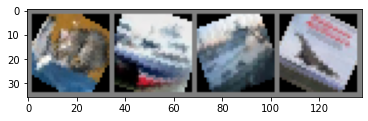

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane


In [12]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# Beginning of Mo's code 
# Tutorial:
# 5. Test the network on the test data
# We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

# We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. 
# If the prediction is correct, we add the sample to the list of correct predictions.

# Okay, first step. Let us display an image from the test set to get familiar.

#create an iterator for testloader??
dataiter = iter(testloader)
#iterate and set two variables to the sample/observation
images, labels = dataiter.next()

# print images and their class
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Okay, now let us see what the neural network thinks these examples above are:
outputs = net(images)
# The outputs are energies for the 10 classes. The higher the energy for a class, 
# the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))
# End of Mo's code

In [13]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

# Beginning of Mo's code 

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# End of Mo's code

Here you can evaluate the overall accuracy of the trained classifier (this is optional).
Accuracy of the network on the 10000 test images: 49 %


In [14]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# Beginning of Mo's code 

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
# End of Mo's code

Here you can evaluate the per-class accuracy of the trained classifier (this is optional).
Accuracy for class: plane is 57.1 %
Accuracy for class: car   is 57.1 %
Accuracy for class: bird  is 39.4 %
Accuracy for class: cat   is 31.9 %
Accuracy for class: deer  is 29.9 %
Accuracy for class: dog   is 48.2 %
Accuracy for class: frog  is 58.2 %
Accuracy for class: horse is 67.8 %
Accuracy for class: ship  is 57.3 %
Accuracy for class: truck is 54.6 %


## 1.8 Autograding and Final Tests

In [15]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                  'Make sure you read and follow the instructions provided as Important Notes' + \
                                  '(especially, the "Model Class Naming" part).'

cifar_net_path = './cifar_net.pth'

assert os.path.exists(cifar_net_path), 'You have not stored the trained model properly. '+  \
                                       'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(cifar_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'



if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(cifar_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=30, translate=(0.01, 0.01), scale=(0.9, 1.1), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

test_pre_tranformation = transforms.Compose(transformation_list)

cifar_root = '/home/jovyan/work/release/CNN-lib/data_cifar' 
testset = torchvision.datasets.CIFAR10(root=cifar_root, train=False,
                                       download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

Accuracy of plane : 57 %
Accuracy of   car : 55 %
Accuracy of  bird : 42 %
Accuracy of   cat : 32 %
Accuracy of  deer : 30 %
Accuracy of   dog : 49 %
Accuracy of  frog : 57 %
Accuracy of horse : 68 %
Accuracy of  ship : 55 %
Accuracy of truck : 56 %
----------
Overall Testing Accuracy: 50.44 %%


In [16]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# 2. Digit Recognition Using the MNIST Data

## 2.1 Loading the Data

In [17]:
message = 'You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. \n'
message = message + '**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the'
message = message + ' test pre-processing transformations in the "Autograding and Final Tests" section before'
message = message + ' training models for long periods of time.'
print(message)

classes = list(str(i) for i in range(10))

# Beginning of Mo's code 

# transform = transforms.Compose([
#     transforms.RandomAffine(degrees=30, translate=(0.01, 0.01), scale=(0.9, 1.1), shear=None, resample=0, fillcolor=0),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize([0.5], [0.5])])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='/home/jovyan/work/release/CNN-lib/data_mnist', train=True,
                                        download=False, transform=transform)
 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='/home/jovyan/work/release/CNN-lib/data_mnist', train=False,
                                       download=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
# End of Mo's code

You can implement the pre-processing transformations, data sets, data loaders, etc. in this cell. 
**Important Note**: Read the "Grading Reference Pre-processing" bullet, and look at the test pre-processing transformations in the "Autograding and Final Tests" section before training models for long periods of time.


You can visualize some of the pre-processed images here (This is optional and only for your own reference).


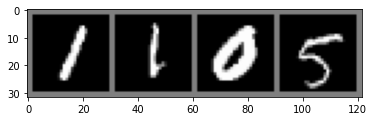

1     1     0     5    


In [18]:
message = 'You can visualize some of the pre-processed images here (This is optional and only for your own reference).'
print(message)
# Beginning of Mo's code 

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# End of Mo's code

# 2.2 Defining the Model

**Important Note**: As mentioned above, make sure you name the neural module class as `Net`. In other words, you are supposed to have the following lines somewhere in your network definition:

```
import torch.nn as nn
class Net(nn.Module):
   ...
```


##### You can define the neural architecture and instantiate it in this cell.
##### You can choose and change your architecture as you please.
- You can have shallow networks, or deep ones.
- You can customize the number of neural units in each layer and the depth of the network.
- You are free to use convolutional, and non-convolutional layers. (self.sonv1 & self.conv2?)
- You can employ batch normalization if you would like to.- You can use any type of non-linear layers as you please. Tanh, Sigmoid, and ReLU are some common activation functions.
- You can use any kind of pooling layers you deem appropriate. (self.pool?)
    
below we are using:
    
torch.nn.:
- Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
            Applies a 2D convolution over an input signal composed of several input planes.
        
- MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
            Applies a 2D max pooling over an input signal composed of several input planes.
- Linear(in_features, out_features, bias=True, device=None, dtype=None)
            Applies a linear transformation to the incoming data:
        .functional.relu(input, inplace=False) → Tensor
            Applies the rectified linear unit function element-wise.

- torch.flatten(input, start_dim=0, end_dim=- 1) → Tensor
        Flattens input by reshaping it into a one-dimensional tensor. 
        If start_dim or end_dim are passed, only dimensions starting with start_dim and ending with end_dim are flattened. The order of elements in input is unchanged.

Post #891  
To decide the number of input features your function can take, you first need to figure out what is the output pixel value of your final conv2d. Let's say your final conv2d function returns a 3x3 pixel image with output channels as 50, in such case the input features to your linear function should be 3x3x50 and you can have any number of output features.

The pixel size (H*W) of your image after applying Conv2d is this:

- Input: $\left(N, C_{i n}, H_{i n}, W_{i n}\right)$ or $\left(C_{i n}, H_{i n}, W_{i n}\right)$
- output: $\left(N, C_{\text {out }}, H_{\text {out }}, W_{\text {out }}\right)$ or $\left(C_{\text {out }}, H_{\text {out }}, W_{\text {out }}\right)$, where

$
\begin{aligned}
&H_{\text {out }}=\left\lfloor\frac{H_{\text {in }}+2 \times \text { padding }[0]-\operatorname{dilation}[0] \times(\text { kernel_size }[0]-1)-1}{\operatorname{stride}[0]}+1\right\rfloor \\
&W_{\text {out }}=\left\lfloor\frac{W_{\text {in }}+2 \times \text { padding }[1]-\operatorname{dilation}[1] \times(\text { kernel_size }[1]-1)-1}{\operatorname{stride}[1]}+1\right\rfloor
\end{aligned}
$

Please refer to pytorch Conv2d reference link https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html to know more details.  
You can also refer to Text Book Page 410 (Example - Classifying MNIST) to get an idea of how this works. 

In [19]:
conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
img = torch.rand(1, 6, 50, 50)
print(conv2(img).shape)

torch.Size([1, 16, 46, 46])


To decide the number of input features linear() can take, you need to figure out the pixel value of the preceeding conv2d call's output. 
If conv2d() returns a 3x3 pixel image with 50 output channels, in_features linear() would be 3x3x50.

        
        calculate H & W of self.conv2 output from 
        I GOT STUCK HERE. I WENT TO TUESDAY OFFICE HOURS 5 MIN LATE AND NO ONE WAS THERE
        I DIDN'T GET AN ANSWER TO MY POST #1032 ABOUT POST #815

        H_in = 
        H = 
        W =
        Linear(in_features, out_features, bias=True, device=None, dtype=None)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc1 = nn.Linear(nn.LazyLinear, 120)
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.fc(x) # will raise a shape mismatch here        
        
        
        print(list(conv2.shape()))
      It seems self.conv2 has no shape attribute.

In [21]:
message = 'You can define the neural architecture and instantiate it in this cell.'
print(message)

# Beginning of Mo's code 

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5)
        
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5)
       
        self.pool = nn.MaxPool2d(2, 2)

        #calculate number of features in self.conv2.
        #feat = self.conv2.c * self.conv2.h * self.conv2.w
        #self.conv2.c = 16
        #self.conv2.h = 
        
        #https://pytorch.org/docs/stable/generated/torch.nn.LazyLinear.html
        #but, "module 'torch.nn' has no attribute 'LazyLinear"?
        self.fc1 = torch.nn.LazyLinear(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x)) #relu is an activation function
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

    ####################
    
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Sequential(         
#             nn.Conv2d(
#                 in_channels=1,              
#                 out_channels=16,            
#                 kernel_size=5,              
#                 stride=1,                   
#                 padding=2,                  
#             ),                              
#             nn.ReLU(),                      
#             nn.MaxPool2d(kernel_size=2),    
#         )
#         self.conv2 = nn.Sequential(         
#             nn.Conv2d(16, 32, 5, 1, 2),     
#             nn.ReLU(),                      
#             nn.MaxPool2d(2),                
#         )
#         # fully connected layer, output 10 classes
#         self.out = nn.Linear(32 * 7 * 7, 10)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
#         x = x.view(x.size(0), -1)       
#         output = self.out(x)
#         return output, x    # return x for visualization
# net = Net()
# End of Mo's code

You can define the neural architecture and instantiate it in this cell.


AttributeError: module 'torch.nn' has no attribute 'LazyLinear'

# 2.3 Initializing the Neural Model

It may be a better idea to fully control the initialization process of the neural weights rather than leaving it to the default procedure chosen by pytorch.

Here is pytorch's documentation about different initialization methods: https://pytorch.org/docs/stable/nn.init.html

Some common layer initializations include the Xavier (a.k.a. Glorot), and orthogonal initializations.

In [ ]:
message = 'You can initialize the neural weights here, and not leave it to the library default (this is optional).'
print(message)

# your code here
# raise NotImplementedError

# 2.4 Defining The Loss Function and The Optimizer

In [ ]:
message = 'You can define the loss function and the optimizer of interest here.'
print(message)

# Beginning of Mo's code 

criterion = nn.CrossEntropyLoss() #Classification Cross-Entropy loss
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) #SGD with momentum

# End of Mo's code

# 2.5 Training the Model

**Important Note**: In order for the autograder not to time-out due to training during grading, please make sure you wrap your training code within the following conditional statement:

```
if perform_computation:
   # Place any computationally intensive training/optimization code here
    
```

In [ ]:
if perform_computation:
    message = 'You can define the training loop and forward-backward propagation here.'
    print(message)
    
# Beginning of Mo's code 
    for epoch in range(2):  # loop over the dataset (our data iterator) multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]; ie feed the inputs to the network
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward +outputs = net(inputs) backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

    # End of Mo's code

# 2.6 Storing the Model

**Important Note**: In order for the autograder not to overwrite your model with empty (untrained) model, please make sure you wrap your code within the following conditional statement:

```
if perform_computation:
   # Save your trained model here
    
```

In [ ]:
message = 'Here you should store the model at "./mnist_net.pth" .'
print(message)

if perform_computation:
    # Beginning of Mo's code 
    
    # Save trained MNIST classification model here
    PATH = './mnist_net.pth'
    torch.save(net.state_dict(), PATH)
    
    # End of Mo's code

# 2.7 Evaluating the Trained Model

In [ ]:
message = 'Here you can visualize a bunch of examples and print the prediction of the trained classifier (this is optional).'
print(message)

# Beginning of Mo's code 
# Tutorial:
# 5. Test the network on the test data
# We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

# We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. 
# If the prediction is correct, we add the sample to the list of correct predictions.

# Okay, first step. Let us display an image from the test set to get familiar.

#create an iterator for testloader??
dataiter = iter(testloader)
#iterate and set two variables to the sample/observation
images, labels = dataiter.next()

# print images and their class
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Okay, now let us see what the neural network thinks these examples above are:
outputs = net(images)
# The outputs are energies for the 10 classes. The higher the energy for a class, 
# the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))
# End of Mo's code

In [ ]:
message = 'Here you can evaluate the overall accuracy of the trained classifier (this is optional).'
print(message)

# Beginning of Mo's code 

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# End of Mo's code

In [ ]:
message = 'Here you can evaluate the per-class accuracy of the trained classifier (this is optional).'
print(message)

# Beginning of Mo's code 

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
# End of Mo's code

## 2.8 Autograding and Final Tests

In [ ]:
assert 'Net' in globals().keys(), 'The Net class was not defined earlier. ' + \
                                 'Make sure you read and follow the instructions provided as Important Notes' + \
                                 '(especially, the "Model Class Naming" part).'

mnist_net_path = './mnist_net.pth'

assert os.path.exists(mnist_net_path), 'You have not stored the trained model properly. ' + \
                                      'Make sure you read and follow the instructions provided as Important Notes.'

assert os.path.getsize(mnist_net_path) < 1000000, 'The size of your trained model exceeds 1 MB.'

if 'net' in globals():
    del net
net = Net()
net.load_state_dict(torch.load(mnist_net_path))
net = net.eval()

# Disclaimer: Most of the following code was adopted from Pytorch's Documentation and Examples
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

transformation_list = [transforms.RandomAffine(degrees=60, translate=(0.2, 0.2), scale=(0.5, 2.), 
                                               shear=None, resample=0, fillcolor=0),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))]

test_pre_tranformation = transforms.Compose(transformation_list)

mnist_root = '/home/jovyan/work/release/CNN-lib/data_mnist' 
testset = torchvision.datasets.MNIST(root=mnist_root, train=False,
                                     download=False, transform=test_pre_tranformation)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))
print('----------')
print(f'Overall Testing Accuracy: {100. * sum(class_correct) / sum(class_total)} %%')

In [ ]:
# "Digit Recognition Test: Checking the accuracy on the MNIST Images"
